In [1]:
# DATASET = 'SST5'
DATASET = 'SST2'
BSZ = 32
EPOCH = 8
MODEL = 'bert'
# MODEL = 'roberta'
# MODEL = 'xlnet'
# MODEL = 'distilbert'
# MODEL = 'edm-roberta'

KOKONOTEST = 'D_' + DATASET + '_M_' + MODEL + '_B_' + str(BSZ) + '_E_' + str(EPOCH)
print(KOKONOTEST)

D_SST2_M_bert_B_32_E_8


### View GPU

In [2]:
!nvidia-smi

Sun Apr 30 06:59:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:20:00.0 Off |                  N/A |
| 30%   29C    P8    27W / 200W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Some Installation

In [3]:
!pip install --upgrade pip
!pip install -q transformers==4.28.1
!pip install git+https://github.com/huggingface/transformers
!pip install fastai==1.0.58
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install SentencePiece
!pip install scikit-learn
    
!pip list | grep -E 'transformers|tokenizers'

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8qroams1
  ERROR: Error [Errno 2] No such file or directory: 'git': 'git' while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
Looking in links: https://download.pytorch.org/whl/torch_stable.html
tokenizers             0.13.3
transformers           4.28.1


### Import Libraries

In [4]:
import fastai
import transformers
print('fastai version: %s' %(fastai.__version__))
print('transformers version: %s' %(transformers.__version__))

fastai version: 1.0.58
transformers version: 4.28.1


In [5]:
device = 'cuda'
import numpy as np
import pandas as pd
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

In [6]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

In [7]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True # speed up with gpu
        torch.backends.cudnn.benchmark = False

### Set Path

In [8]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
ROOT_PATH = '/home'

In [10]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [11]:
# for dirname, _, filenames in os.walk('/content/drive/My Drive/LAB/kge_sentiment_anlysis'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [12]:
#  # tokenizer version
# Version = 'T_v_1.3.3'

# root_folder = os.path.abspath(os.path.join('/content/drive/My Drive/07_research_main/lab_10', Version))

# tokenizer_folder = os.path.abspath(os.path.join(root_folder, 'tokenizer'))

In [13]:
 # model version
Version = 'M_v_7.0.0'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

model_folder = os.path.abspath(os.path.join(root_folder, 'model'))
checkpath(model_folder)

### Set Arguments

In [14]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig)
}

In [15]:
# Data selection

if DATASET == 'SST5':
    dataset = 'SST5'
    DATA_ROOT = Path(os.path.join(ROOT_PATH, 'finetune_dataset/kge_sentiment_analysis'))
    train_cols = 'Phrase'
    label_cols = 'Sentiment'
    classification_head = 5
elif DATASET == 'SST2':
    dataset = 'SST2'
    DATA_ROOT = Path(os.path.join(ROOT_PATH, 'finetune_dataset/IMDB_MovieReviews'))
    train_cols = 'review'
    label_cols = 'sentiment'
    classification_head = 2


# Parameters

lr = 1e-5
bsz = BSZ
epoch = EPOCH

# model_name = 'bsz2048_DEM-RoBERTa.pkl'

seed = 42
use_fp16 = False
BOOM = 4

# Model selection

if MODEL == 'bert':
    model_type = 'bert'
    pretrained_model_name='bert-base-uncased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'roberta':
    model_type = 'roberta'
    pretrained_model_name = 'roberta-large'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'xlnet':
    model_type = 'xlnet'
    pretrained_model_name = 'xlnet-base-cased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'distilbert':
    model_type = 'distilbert'
    pretrained_model_name = 'distilbert-base-uncased'
    pretrained_tokenizer_name = pretrained_model_name
    EDM = False
elif MODEL == 'edm-roberta':
    model_type = 'roberta'
    pretrained_model_name = 'roberta-large'
    pretrained_tokenizer_name = pretrained_model_name#tokenizer_folder
    EDM = True

# model_type = 'xlm'
# pretrained_model_name = 'xlm-clm-enfr-1024'
# pretrained_tokenizer_name = pretrained_model_name
# EDM = False

In [16]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### Dataset Import

In [17]:
seed_all(seed)

In [18]:
if(dataset == 'SST5'):
  train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
  test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep='\t')

In [19]:
if(dataset == 'SST2'):
  from sklearn.model_selection import train_test_split
  df = pd.read_csv(DATA_ROOT / 'IMDB_Dataset.csv.zip')
  df['Sentiment'] = df['sentiment'].replace(['negative', 'positive'], [0, 1])
  train, test = train_test_split(df, test_size=0.5, random_state=seed)

In [20]:
print(train.shape, test.shape)
train.head()

(25000, 3) (25000, 3)


,review,sentiment,Sentiment
25858,"""Congo"" is based on the best-selling novel by ...",negative,0
10784,"Wow, here it finally is; the action ""movie"" wi...",negative,0
24807,'Identity . . . . I am part of my surrounding...,positive,1
49534,"""Sir"" John Gielgud must have become senile to ...",negative,0
3345,Below average movie with poor music considerin...,negative,0


### Data pre-processing

In [21]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type='bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.model_max_length
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

- bert:       [CLS] + tokens + [SEP] + padding

- roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

- distilbert: [CLS] + tokens + [SEP] + padding

- xlnet:      padding + tokens + [SEP] + [CLS]


In [22]:
# # from transformers import RobertaTokenizerFast
# from transformers import RobertaTokenizer

# MAX_LEN = 128
# # Create the tokenizer from a trained one
# # transformer_tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)
# transformer_tokenizer = RobertaTokenizer.from_pretrained(tokenizer_folder)#, max_len=MAX_LEN)

In [23]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_tokenizer_name)
transformer_tokenizer.model_max_length = 128#512

transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [24]:
transformer_tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

#### Custom Numericallizer

In [25]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#### Custom Processor

In [26]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


#### Settings up the Databunch

In [27]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [28]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
# print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

In [29]:
databunch = (TextList.from_df(train, cols=train_cols, processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= label_cols)
             .add_test(test)
             .databunch(bs=bsz, pad_first=pad_first, pad_idx=pad_idx))

In [30]:
# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)
# databunch.show_batch()

In [31]:
# print('[CLS] id: ', transformer_tokenizer.cls_token_id)
# print('[SEP] id: ', transformer_tokenizer.sep_token_id)
# print('[PAD] id: ', pad_idx)
# test_one_batch = databunch.one_batch()[0]
# print('Batch shape: ', test_one_batch.shape)
# print(test_one_batch)

### Import roBerta + Boom

In [32]:
from transformers import RobertaForMaskedLM, RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaClassificationHead, RobertaPreTrainedModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from typing import List, Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch import Tensor
logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"
_TOKENIZER_FOR_DOC = "RobertaTokenizer"

ROBERTA_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `({0})`):
            Indices of input sequence tokens in the vocabulary.
            Indices can be obtained using [`RobertaTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.
            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.FloatTensor` of shape `({0})`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
            [What are attention masks?](../glossary#attention-mask)
        token_type_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Segment token indices to indicate first and second portions of the inputs. Indices are selected in `[0,
            1]`:
            - 0 corresponds to a *sentence A* token,
            - 1 corresponds to a *sentence B* token.
            [What are token type IDs?](../glossary#token-type-ids)
        position_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.
            [What are position IDs?](../glossary#position-ids)
        head_mask (`torch.FloatTensor` of shape `(num_heads,)` or `(num_layers, num_heads)`, *optional*):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in `[0, 1]`:
            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.
        inputs_embeds (`torch.FloatTensor` of shape `({0}, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [33]:
class GELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)

In [34]:
class Boom_new(nn.Module):
     def __init__(self, in_features: int, out_features: int, dropout=0.1, shortcut: bool = True, device=None, dtype=None) -> None:
         factory_kwargs = {'device': device, 'dtype': dtype}
         super(Boom_new, self).__init__()

         self.linear1 = nn.Linear(in_features, out_features)
         self.dropout = nn.Dropout(dropout) if dropout else None
         if not shortcut:
             self.linear2 = nn.Linear(out_features, in_features)
         self.shortcut = shortcut
         self.act = GELU()
 
     def forward(self, input: Tensor) -> Tensor:
        #  print('A  ', input.shape, type(input))
         x = self.act(self.linear1(input))
        #  print('B  ', x.shape, type(x))
         if self.dropout: x = self.dropout(x)
        #  print('C  ', x.shape, type(x))
         if self.shortcut:
             ninp = input.shape[-1]
             x = torch.narrow(x, -1, 0, x.shape[-1] // ninp * ninp)
            #  print('D  ', x.shape, type(x))
             x = x.view(*x.shape[:-1], x.shape[-1] // ninp, ninp)
            #  print('E  ', x.shape, type(x))
             z = x.sum(dim=-2)
            #  print('F  ', x.shape, type(x))
         else:
             z = self.linear2(x)
            #  print('G  ', x.shape, type(x))
        #  print('Z  ', x.shape, type(x))
         return z

In [35]:
class ModifiedRobertaForSequenceClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.Boom = Boom_new(config.hidden_size, (config.hidden_size * BOOM))
        self.LINEAR = nn.Linear(config.hidden_size,config.hidden_size)
        self.classifier = RobertaClassificationHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        processor_class=_TOKENIZER_FOR_DOC,
        checkpoint="cardiffnlp/twitter-roberta-base-emotion",
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output="'optimism'",
        expected_loss=0.08,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        sequence_output = self.Boom(sequence_output)
        sequence_output = self.LINEAR(sequence_output)
        logits = self.classifier(sequence_output)

        # return logits

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### Define Model

In [36]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = classification_head

if EDM: config.num_hidden_layers = 10

if use_fp16: config.torch_dtype = "float16"

print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [37]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = transformer_model

    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]
        return logits

In [38]:
if(EDM):
      transformer_model = ModifiedRobertaForSequenceClassification.from_pretrained(model_folder, config=config)
  # transformer_model = ModifiedRobertaForSequenceClassification.from_pretrained(pretrained_model_name, config=config)
else:
      transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)

custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [39]:
# transformer_model = RobertaForSequenceClassification.from_pretrained(model_folder, config=config)

# custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

### Learner: Optimizer & Metric

In [40]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, custom_transformer_model,
                  opt_func = CustomAdamW,
                  metrics=[accuracy, error_rate])

learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

In [41]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

#### Discriminative Fine-tuning and Gradual unfreezing (Optional)

In [42]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [128, 768]           23,440,896 True      
______________________________________________________________________
Embedding            [128, 768]           393,216    True      
______________________________________________________________________
Embedding            [128, 768]           1,536      True      
______________________________________________________________________
LayerNorm            [128, 768]           1,536      True      
______________________________________________________________________
Dropout              [128, 768]           0          False     
______________________________________________________________________
Linear               [128, 768]           590,592    True      
______________________________________________________________________
Linear               [128, 768]           590,592    True      
_______________________________________

### Start training

In [43]:
# learner.save('untrain')

In [44]:
# learner.load('untrain')

In [45]:
seed_all(seed)

In [46]:
print(lr, bsz, use_fp16, BOOM, pretrained_model_name, EDM)

1e-05 32 False 4 bert-base-uncased False


In [47]:
# learner.fit(epochs=epoch, lr=lr)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 5.25E-06


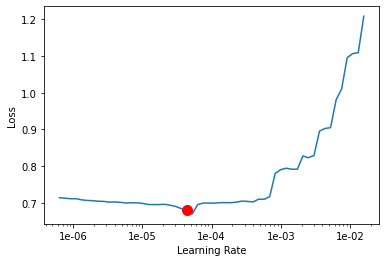

In [48]:
learner.lr_find()
learner.recorder.plot(skip_end=10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.345701,0.300430,0.872000,0.128000,02:38
1,0.286510,0.276342,0.879600,0.120400,02:45
2,0.220046,0.267769,0.884800,0.115200,02:46
3,0.127056,0.325552,0.878800,0.121200,02:46
4,0.075838,0.434584,0.875200,0.124800,02:48
5,0.037336,0.473993,0.884800,0.115200,02:44
6,0.021591,0.486450,0.888400,0.111600,02:46
7,0.019679,0.490679,0.886400,0.113600,02:45


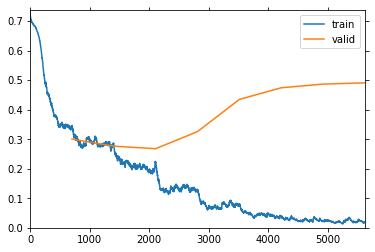

In [49]:
learner.fit_one_cycle(epoch, max_lr=lr, moms=(0.8, 0.9))

### Evaluation

In [50]:
learner.predict('This movie is the worst one so far')

(Category negative, tensor(0), tensor([9.9951e-01, 4.9236e-04]))

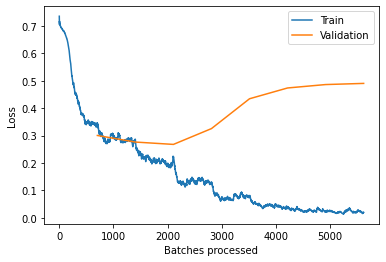

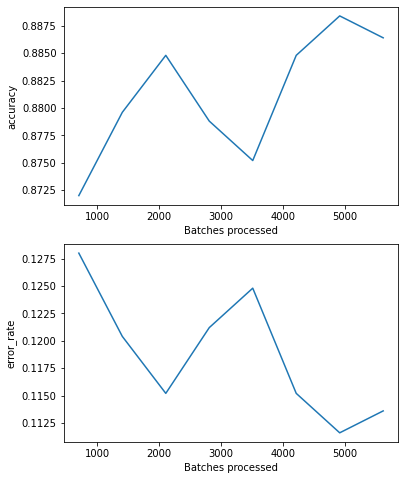

In [51]:
learner.recorder.plot_losses()
learner.recorder.plot_metrics()

In [52]:
learner.save(os.path.join(ROOT_PATH, 'results', KOKONOTEST))

In [53]:
learner.show_results()

text,target,prediction
"[CLS] drones , ethnic drumming , bad synthesizer pip ##ing , children singing . the most patron ##izing "" world music "" im ##agi ##nable . this is a tourist film , and a lou ##sy one . what really kills it is the inc ##oh ##ere ##nt sequences . india , egypt , south america , africa , etc , etc . no transitions , no visual explanation of",negative,negative
"[CLS] some science ##y people go down in a cave for some reason and there ' s some sort of creature that ' s killing them . < br / > < br / > i usually give a more detailed plot , but i wasn ' t paying too much attention to this . overall , it was dull and the only time you ' ll be really paying",negative,negative
"[CLS] i wasn ' t at all a fan of the 2005 gore fest hit "" hostel "" , and most of these lame ass knock - offs are just as bad or worse - yet "" live feed "" managed to keep me somewhat entertained for about the first 30 minutes . started off with plenty of sex and sl ##ea ##zy settings , followed by some good death",negative,negative
"[CLS] i wouldn ' t call "" we ' re back ! a dinosaur ' s story "" simply a kidd ##ie version of "" jurassic park "" . i found it more interesting than that . like the former , it calls into question the security of bringing beings from one era into ours . but it really opens my eyes when i see who provided the voices :",positive,positive
"[CLS] what can be said of this independent effort beyond the fact that it was shot with television cameras , and whether that was by con ##ce ##it or budget constraints doesn ' t make the watching of this variation on a theme by romero any easier . i was constantly reminded that i was watching somebody ' s school project , at best derivative , at worst cheap .",negative,negative


#### Export Learner (model)

In [54]:
# learner.export(model_name)
# !mv ./export.pkl /content/drive/My\ Drive/LAB/kge_sentiment_analysis
# !mv /content/drive/My\ Drive/LAB/kge_sentiment_analysis/export.pkl /content/drive/My\ Drive/LAB/bsz2048_DEM-RoBERTa.pkl

In [55]:
# path = '/content/drive/My Drive/LAB/'
# export_learner = load_learner(path, file = model_name)

In [56]:
# export_learner.predict('This is the worst movie of 2020')

#### Creating prediction

In [57]:
# def get_preds_as_nparray(ds_type) -> np.ndarray:
#     preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
#     sampler = [i for i in databunch.dl(ds_type).sampler]
#     reverse_sampler = np.argsort(sampler)
#     return preds[reverse_sampler, :]

# test_preds = get_preds_as_nparray(DatasetType.Test)

In [58]:
# sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
# sample_submission['Sentiment'] = np.argmax(test_preds, axis = 1)
# sample_submission.to_csv('prediction.csv', index = False)

In [59]:
# test.head()

In [60]:
# sample_submission.head()

In [61]:
# from IPython.display import HTML

# def create_download_link(title = 'Download CSV file', filename = 'data.csv'):
#     html = '<a href=(filename)->(title)</a>'
#     html = html.format(title=title, filename=filename)
#     return HTML(html)

# create_download_link(filename='prediciton.csv')